# 2025 Spring ORF307 Final Project Solutions

Instructor: B. Stellato

AIs: Yanjun Liu, Qishuo Yin, Chenyu Yu, and Kaiwen Zhang

___

## Instructions
**Exam files:** the exam files are available to download at [THIS LINK.](https://www.dropbox.com/scl/fo/b6an98pypucpvdhb81osz/AHSPIHMuLOtnttr-CDG6ZZY?rlkey=6wph0csyr9gldp2lo7akkx4ln&st=ckxp1xua&dl=0)

**Date and time:** From May 8, 2025 at 00:01 am to May 11, 2025 at 7:00pm.

- Total time after download: 24 hours. No late submissions allowed. Note that the deadline is either 24 hours after download, or May 11, 2025 at 7:00pm, **whichever comes first**.

## Exam Rules
- You are allowed to use all course materials on the midterm (lecture notes, books, precept materials, code, and homeworks). But you cannot use internet to search for answers.
- You have to justify all your answers. If you use code from the course materials, you have to explain what each step means.
- You cannot communicate with anyone during the exam.
- No late submissions allowed. Make sure your submission goes through on time. You can resubmit as many times as you like until your time expires.
- The exam is to be submitted electronically on Gradescope before 7:00pm on the final day.

# Final Exam

## Introduction 

For this final project, you will work with the Fashion MNIST dataset including thousands of images of clothes, which we have provided in CSV format. 

You will work with a pre-processed version of this dataset where each label is +1 if the image is a shirt and -1 otherwise.

To load the dataset, ensure the following files are in a folder called `data/` in your working directory: `X_train.csv`, `y_train.csv`, `X_test.csv`, `y_test.csv`. Then run the following code to import the packages and load the data

In [1]:
import numpy as np
np.set_printoptions(precision=4)  # Print few decimal places
np.set_printoptions(suppress=True)  # Suppress scientific notation
import cvxpy as cp
import pandas as pd
from numpy.linalg import cholesky as llt
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv(f"data/X_train.csv").values
y_train = pd.read_csv(f"data/y_train.csv").values.ravel()
X_test = pd.read_csv(f"data/X_test.csv").values
y_test = pd.read_csv(f"data/y_test.csv").values.ravel()

n_train, m = X_train.shape
n_test, m = X_test.shape

print("-" * 50)
print("Fashion MNIST dataset")
print("-" * 50)
print(f"Number of features: {m}  ({int(np.sqrt(m))} x {int(np.sqrt(m))} pixels)")
print(f"Training set:")
print(f"  • Samples: {n_train}")
print(f"  • Value range: [{X_train.min():.2f}, {X_train.max():.2f}]")
print(f"Test set:")
print(f"  • Samples: {n_test}")
print(f"  • Value range: [{X_train.min():.2f}, {X_train.max():.2f}]")

--------------------------------------------------
Fashion MNIST dataset
--------------------------------------------------
Number of features: 784  (28 x 28 pixels)
Training set:
  • Samples: 5000
  • Value range: [0.00, 255.00]
Test set:
  • Samples: 1000
  • Value range: [0.00, 255.00]


Now, let's visualize a couple of images

In [3]:
def visualize_images(*images):
    n_images = len(images)
    fig, axes = plt.subplots(1, n_images, figsize=(14,6))
    if n_images == 1:
        axes = [axes]   
    for i, (ax, img) in enumerate(zip(axes, images)):
        img_reshaped = img.reshape(28, 28)
        im = ax.imshow(img_reshaped, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()

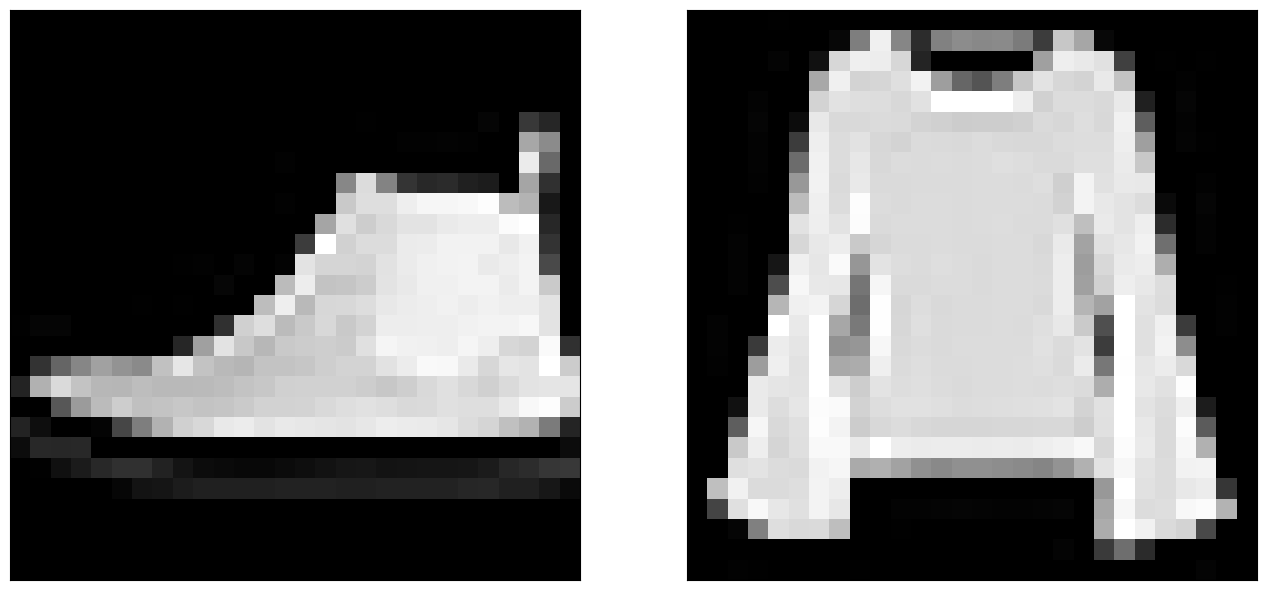

In [4]:
example_boot = X_train[3]
example_shirt = X_train[0]
visualize_images(example_boot, example_shirt)

# 1. (35 points) Build a Support Vector Machine to correctly classify shirts

1. (5 points) Formulate a Support Vector Machine problem to find a hyperplane $(a, b)$ where $a \in \mathbf{R}^m$ and $b \in \mathbf{R}$ to classify shirts. Given sample $x^{(i)}$, your hyperplane should be $a^Tx^{(i)} + b > 0$ if label $y^{(i)} = 1$ (shirt) or $a^Tx^{(i)} + b < 0$ if label $y^{(i)} = -1$ (not a shirt). You should include a second term in the objective, weighted by parameters $\lambda > 0$ to regularize the $\ell_1$-norm of $a$.

    Note: Remember to normalize the misclassification error by the total number of training samples.

2. (7 points) Run a cross-validation procedure: solve the problem using CVXPY and CLARABEL solver for $\lambda = (0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05)$ and pick the model that has the lowest test error.

    Note, these problems are quite large so it may take a few seconds to solve them. (you may use the argument `verbose=True` to print out the solver progress).

    Here is a utility function to check the test error. For example, you can use it as `error(X_test, y_test, a, b)`

In [42]:
def error(X, y, a, b):
    y_pred = np.sign(X @ a + b)
    return np.mean(y_pred != y)

3. (7 points) Write the training problem as a linear program in inequality form (get rid of all norms in the formulation)

4. (7 points) Write the dual problem and call the dual variables corresponding to the misclassified points as $z \in \mathbf{R}^{\rm n\_train}$.

5. (7 points) Identify which points are misclassified using the dual variables $z$. Visualize the images corresponding to the 5 largest dual variables. How do they compare to a shirt image below?

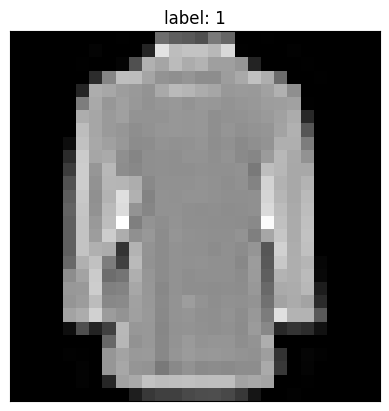

In [58]:
example_shirt = 0
visualize_image(X_train, example_shirt)

# (25 points) computing adversarial examples

We now would like to verify the robustness of our classifier by looking at adversarial examples. To do so, we will consider all images close to a *representative image* and see if appropriate pixel perturbations could confuse our classifier.

1. (10 points) Formulate the problem of finding the closest image, in terms of the $\ell_1$-norm, to the shirt one at index `example_shirt = 0`, that gets misclassified.

    Note: images have pixel intensities between 0 and 255.

2. (5 points) Formulate the problem as a linear program in inequality form without including any norm.

3. (10 points) Solve problem compare the resulting image with the example shirt above. How many pixels are modified? What is the $\ell_1$-norm distance between the images? Plot the images side by side using the `visualize_images` function above and describe what's different.

In [5]:
### Obtain SVM shirt classifier
### Build based on from Chenyu's solution to Q1
class SVM:
    def __init__(self, lambda_val):
        """
        Initialize SVM with L1 regularization parameter.

        Parameters:
        -----------
        lambda_val : float
            Regularization param >=0 .
        """
        if lambda_val < 0:
            raise ValueError("lambda_val must be non-negative.")
        self.lambda_val = lambda_val
        self.a = None
        self.b = None

    def fit(self, X, y, solver=cp.CLARABEL):
        """
        Fit the SVM model to the training data using convex optimization.

        Parameters:
        -----------
        X : np.ndarray, shape (n_samples, n_pix)
            Training feature matrix.
        y : np.ndarray, shape (n_samples,)
            Training labels (±1).
        solver : cvxpy solver, optional
            Solver to use (default: CLARABEL).
        verbose : bool, optional
            Whether to print solver progress (default: False).

        Returns:
        --------
        a : np.ndarray
            Learned weight vector.
        b : float
            Learned bias term.
        """
        n_samples, n_pix = X.shape
        a = cp.Variable(n_pix)
        b = cp.Variable()
        
        hinge_loss = cp.sum(cp.pos(1 - cp.multiply(y, X @ a + b))) / n_samples
        objective = cp.Minimize(hinge_loss + self.lambda_val * cp.norm(a, 1))

        problem = cp.Problem(objective)
        problem.solve(solver=solver)
        
        self.a = a.value
        self.b = b.value
        
        return self.a, self.b

lambda_val = 0.1
svm = SVM(lambda_val)
a, b = svm.fit(X_train, y_train)

# 3 (35 points) Production plannin with quality control via SVM
You are a clothing manufacturer that produces a certain amount of shirts (`n_shirts`) daily but can only inpsect 40% of them due to resource constraints. Your excellent shirt classifier from part 1 wil turn out to be helpful to decide which ones to inspect. The company incurs in various costs:

- Inspection cost: $c = 10$ per item inspected
- False negative (error) cost: $d = 20$ per defective item that reaches a customer (which will not be happy about the purchase)
- True positive (correct) cost (savings): $s = 15$ from catching a defective item before shipping

For each shirt $i$, you need to decide whether to inspect it using binary variable $w_i \in \{0, 1\}$. We will use the trained SVM problem to suggest to inspect the item if it is not classified as a shirt. Specifically, we transform the output of the SVM into a probability with values between $0$ and $1$ using the following function. For an image $i$, the probability of the product to be defective (i.e., not a shirt) is 
$$p^{(i)} = \sigma(- (a^Tx^{(i)} + b)),$$
where $\sigma(x) = 1 / (1 + \exp(-x))$ is the sigmoid function.

1. (5 points) Calculate the predicted probabilities for all training shirt images. Use the `X_shirt_train` images data defined here for convenience.

In [6]:
# get shirt images from training first
shirt_indices_train = np.where(y_train == 1)[0]
X_shirt_train = X_train[shirt_indices_train]
n_shirt_train = X_shirt_train.shape[0]
inspection_capacity_train = int(0.4 * n_shirt_train)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def prob(X, a, b):
    return sigmoid(- (X @ a + b))

prob_train = prob(X_shirt_train, a, b)
print(prob_train)

[0.2836 0.2689 0.0598 ... 0.7721 0.1018 0.2318]


2. (5 points) Run naive approach. Inspect items with larger probability of being defective.

In [7]:
indices_naive_train = np.argsort(prob_train)[-inspection_capacity_train:] 
print(indices_naive_train)

[1040 1489  232 2040  777 1573 1131  619 1855  959 2331 1935 2468 1465
 2462  887 1703  650  870 1065  654 1309  707  799 1448 2335  778 2062
 1412 1977 1760 1113 1033 1248 1689  392 1269 2298 1627  465 1660 1147
 1114 1900 2090  695  285  160  307 1241 1985  479 1517 1092 1121 1249
 1122 1716 2186 1452  889  585 2470 2314  945  140  457 1074 1853 2491
  826  449 1110   76  602 1630 1858 1677 1800  241 2047 2081  192 1529
   16 1173 2217 2195 1998 1680  420 1780 1847  704   17 2324   68 2293
  338 1511 2494 1409 1606 1812 1862 1766  744 1111 1765 1928 1662 2496
  868 2236  828   32 2429  515 1082  682  974  867  118 1424  330 1701
 1398  220  313  262 1658  177 1509 2213  816  541 1302 2437 2205 2345
  784 1651 1727 1740  497  399  858  374 1387 2064  265 1590 1585 1892
 1470 2489 2312  450 2276  348  676 1714  643 1072  708 1174 1239  259
 1969  434 2364  303 1372 1650  344  369 2181 1789  427 2097 2067 2112
  806  151 1077  866 1413 2384  814  416  254 1804  940  752 2209 2001
 2156 

3. (10 points) Define a mixed-integer optimization problem to minimize the expected costm, i.e., the weighted sum of all the components of the objective, weighted by the defective probabilities. Ensure that the number of inspected products is less than `inspection_capacity`.

**Solution**
For each product $i$, if inspected (i.e., $\omega_i = 1$), the cost is $c - p^{(i)} s$; otherwise if not inspected (i.e., $\omega_i = 0$), the cost is $p^{(i)} d$. Therefore, we can formulate the mixed-integer problem below: 
$$
\begin{array}{ll}
    \text{minimize} & \sum_{i=1}^{n\_ shirt} (1-\omega_i) p^{(i)} d + \omega_i (c - p^{(i)} s) \\
    \text{subject to} & \sum_{i=1}^{n\_ shirt} \omega_i \leq inspection\_ capacity
\end{array}
$$

4. (10 points) Solve and compare both approaches on training and test data.

In [8]:
c=10
d=20
s=15
def compute_expected_cost(w, p):
    return np.sum(p * d + w * (c - p * (s + d)))

# Solve MIP
def MIP(X, prob_X):
    n_shirt = X.shape[0]
    inspection_capacity = int(0.4 * n_shirt)
    w = cp.Variable(n_shirt, boolean=True)
    expected_cost = cp.sum(d*prob_X + cp.multiply(w, c - (s + d) * prob_X))
    objective = cp.Minimize(expected_cost)
    constraints = [cp.sum(w) <= inspection_capacity]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCIPY)
    return w.value

### Train data
n_shirt_train = X_shirt_train.shape[0]
prob_train = prob(X_shirt_train, a, b)
# Naive approach
w_naive_train = np.zeros(n_shirt_train)
w_naive_train[indices_naive_train] = 1
cost_naive_train = compute_expected_cost(w_naive_train, prob_train)
print("Trained cost by naive approach: ", cost_naive_train)
# MIP approach
w_MIP_train = MIP(X_shirt_train, prob_train)
cost_MIP_train = compute_expected_cost(w_MIP_train, prob_train)
print("Trained cost by MIP approach: ", cost_MIP_train)


### Test data
shirt_indices_test = np.where(y_test == 1)[0]
X_shirt_test = X_test[shirt_indices_test]
n_shirt_test = X_shirt_test.shape[0]
prob_test = prob(X_shirt_test, a, b)
# Naive approach
w_naive_test = np.zeros(n_shirt_test)
inspection_capacity_test = int(0.4 * n_shirt_test)
indices_naive_test = np.argsort(prob_test)[-inspection_capacity_test:] 
w_naive_test[indices_naive_test] = 1
cost_naive_test = compute_expected_cost(w_naive_test, prob_test)
print("Test cost by naive approach: ", cost_naive_test)
# MIP approach
w_MIP_test = MIP(X_shirt_test, prob_test)
cost_MIP_test = compute_expected_cost(w_MIP_test, prob_test)
print("Test cost by MIP approach: ", cost_MIP_test)


Trained cost by naive approach:  8167.979670830689
Trained cost by MIP approach:  7888.071330607504
Test cost by naive approach:  1461.4243552791104
Test cost by MIP approach:  1448.2352907704458
